# 01. Dataset Preprocessing

Preprocessing dataset gambar sampah untuk persiapan ekstraksi fitur CNN.

**Input:** Dataset gambar sampah (Organik, Anorganik, Lainnya)  
**Output:** Dataset yang sudah dipreprocessing dan dibagi menjadi train/val/test

## Import Libraries & Setup

In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np
from pathlib import Path
import time
from tqdm.auto import tqdm
import json
import zipfile

# Image processing
from PIL import Image
import cv2

# PyTorch
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## Dataset Loading & Exploration

In [2]:
DATASET_PATH = "/kaggle/input/dataset-sampah"

if not os.path.exists(DATASET_PATH):
    DATASET_PATH = "./dataset"
    print(f"Using local dataset path: {DATASET_PATH}")
else:
    print(f"Using Kaggle dataset path: {DATASET_PATH}")

CLASSES = ['Organik', 'Anorganik', 'Lainnya']
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

print(f"Classes: {CLASSES}")
print(f"Class mapping: {CLASS_TO_IDX}")

Using Kaggle dataset path: /kaggle/input/dataset-sampah
Classes: ['Organik', 'Anorganik', 'Lainnya']
Class mapping: {'Organik': 0, 'Anorganik': 1, 'Lainnya': 2}


In [3]:
def load_dataset_info(dataset_path):
    data_info = []
    class_counts = {}
    
    print("Scanning dataset...")
    
    for class_name in CLASSES:
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} not found!")
            continue
            
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
        image_files = []
        
        for ext in image_extensions:
            image_files.extend(Path(class_path).glob(f'*{ext}'))
            image_files.extend(Path(class_path).glob(f'*{ext.upper()}'))
        
        class_counts[class_name] = len(image_files)
        
        for img_path in image_files:
            data_info.append({
                'image_path': str(img_path),
                'class_name': class_name,
                'class_idx': CLASS_TO_IDX[class_name]
            })
    
    df = pd.DataFrame(data_info)
    
    print(f"\nDataset Summary:")
    print(f"Total images: {len(df)}")
    for class_name, count in class_counts.items():
        print(f"-> {class_name}: {count} images")
    
    return df, class_counts

start_time = time.time()
df_dataset, class_counts = load_dataset_info(DATASET_PATH)
load_time = time.time() - start_time

print(f"\nDataset loading time: {load_time:.2f} seconds")
print(f"Dataset DataFrame shape: {df_dataset.shape}")
print("\nFirst 5 rows:")
df_dataset.head()

Scanning dataset...

Dataset Summary:
Total images: 18000
-> Organik: 6000 images
-> Anorganik: 6000 images
-> Lainnya: 6000 images

Dataset loading time: 0.62 seconds
Dataset DataFrame shape: (18000, 3)

First 5 rows:


,image_path,class_name,class_idx
0,/kaggle/input/dataset-sampah/Organik/Organik21...,Organik,0
1,/kaggle/input/dataset-sampah/Organik/Organik49...,Organik,0
2,/kaggle/input/dataset-sampah/Organik/Organik44...,Organik,0
3,/kaggle/input/dataset-sampah/Organik/Organik14...,Organik,0
4,/kaggle/input/dataset-sampah/Organik/Organik16...,Organik,0


## Dataset Analysis & Visualization

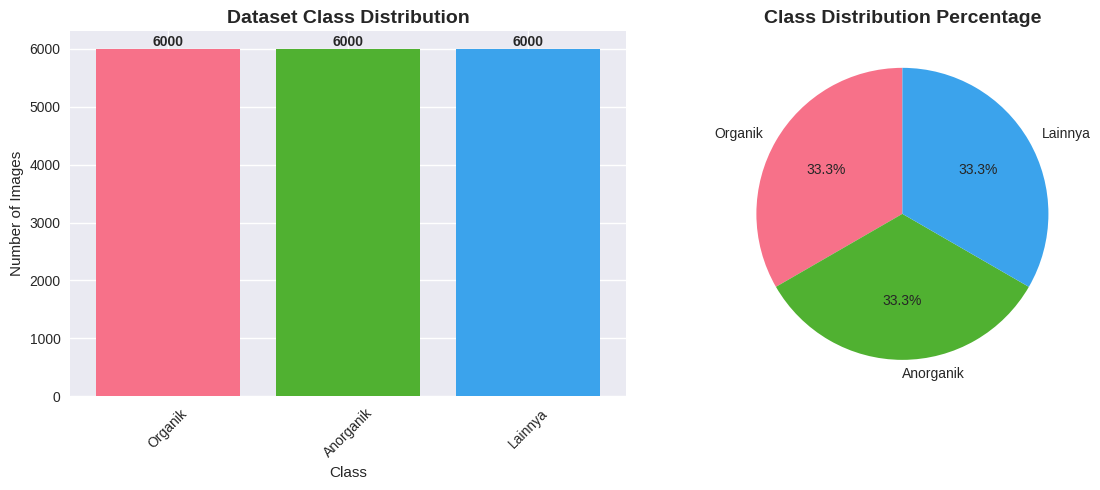


Dataset Statistics:
- Total images: 18,000
- Number of classes: 3
- Images per class (avg): 6,000
- Min class size: 6,000
- Max class size: 6,000
- Class imbalance ratio: 1.00


In [4]:
plt.figure(figsize=(12, 5))

# Bar plot
plt.subplot(1, 2, 1)
class_names = list(class_counts.keys())
class_values = list(class_counts.values())
colors = sns.color_palette("husl", len(class_names))

bars = plt.bar(class_names, class_values, color=colors)
plt.title('Dataset Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

for bar, value in zip(bars, class_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(value), ha='center', va='bottom', fontweight='bold')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(class_values, labels=class_names, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Class Distribution Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistics
print("\nDataset Statistics:")
print(f"- Total images: {len(df_dataset):,}")
print(f"- Number of classes: {len(CLASSES)}")
print(f"- Images per class (avg): {len(df_dataset) // len(CLASSES):,}")
print(f"- Min class size: {min(class_values):,}")
print(f"- Max class size: {max(class_values):,}")
print(f"- Class imbalance ratio: {max(class_values) / min(class_values):.2f}")

## Sample Images Visualization

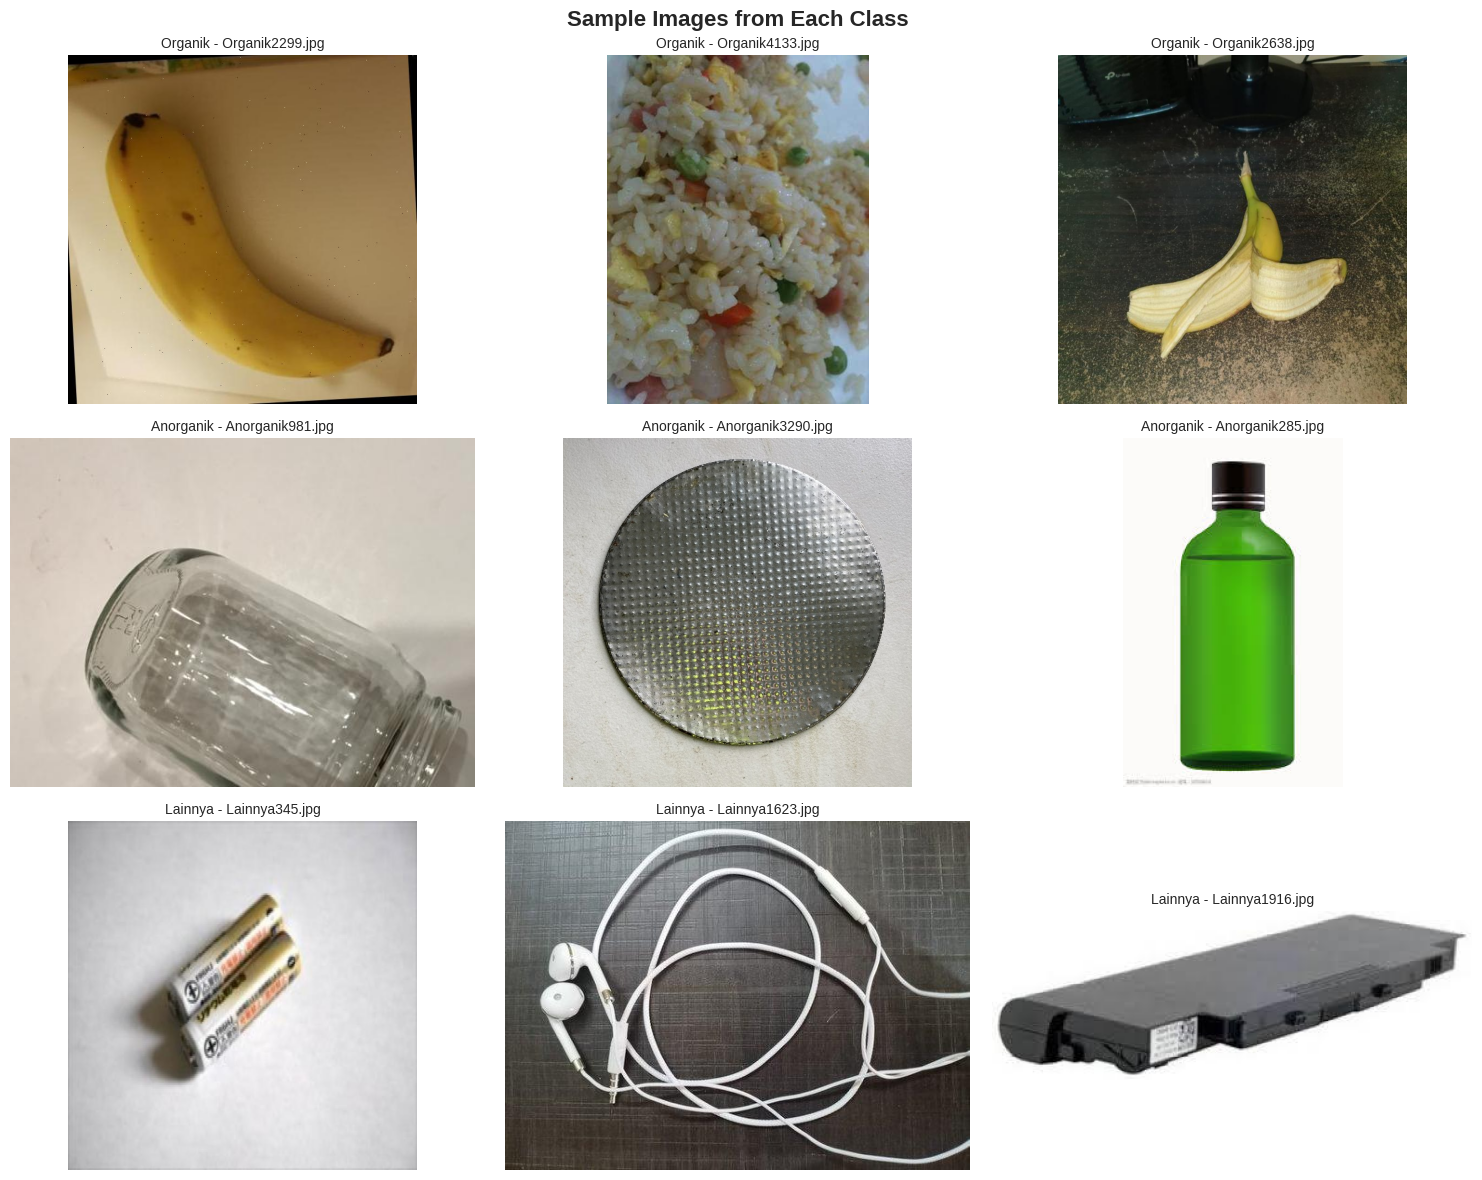

In [5]:
def display_sample_images(df, n_samples=3):
    fig, axes = plt.subplots(len(CLASSES), n_samples, figsize=(15, 12))
    
    for i, class_name in enumerate(CLASSES):
        class_df = df[df['class_name'] == class_name]
        samples = class_df.sample(n=min(n_samples, len(class_df)), random_state=42)
        
        for j, (_, row) in enumerate(samples.iterrows()):
            try:
                img = Image.open(row['image_path'])
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{class_name} - {os.path.basename(row['image_path'])}", 
                                   fontsize=10)
                axes[i, j].axis('off')
            except Exception as e:
                axes[i, j].text(0.5, 0.5, f"Error loading\n{os.path.basename(row['image_path'])}", 
                              ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')
    
    plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

display_sample_images(df_dataset, n_samples=3)

## Image Preprocessing & Transformations

In [6]:
# Define ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224  # Standard CNN input size

# Base transformation (no augmentation)
base_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Training transformation with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/Test transformation (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Transformations defined:")
print(f"- Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"- Normalization: ImageNet mean/std")
print(f"- Augmentation: Flip, Rotation, ColorJitter")

Transformations defined:
- Image size: 224x224
- Normalization: ImageNet mean/std
- Augmentation: Flip, Rotation, ColorJitter


### 🔍 Visualisasi Transformasi & Augmentasi
Menampilkan contoh augmentasi (flip, rotasi, color jitter), efek normalisasi, serta konversi grayscale dan deteksi tepi (edge) untuk dokumentasi ilmiah / tesis.

In [ ]:
# Menampilkan beberapa variasi augmentasi untuk 1 contoh per kelas
import random
from copy import deepcopy

os.makedirs('./preprocessed_data/visualizations', exist_ok=True)

SAMPLES_PER_CLASS = 1
AUG_VARIATIONS = 6

fig, axes = plt.subplots(len(CLASSES), AUG_VARIATIONS + 1, figsize=(3*(AUG_VARIATIONS+1), 3*len(CLASSES)))
fig.suptitle('Contoh Augmentasi per Kelas', fontsize=16, fontweight='bold')

augmentation_steps = [t for t in train_transform.transforms]

for i, cls in enumerate(CLASSES):
    cls_df = df_dataset[df_dataset['class_name']==cls]
    if cls_df.empty:
        continue
    row = cls_df.sample(1, random_state=42).iloc[0]
    img = Image.open(row['image_path']).convert('RGB')
    axes[i,0].imshow(img)
    axes[i,0].set_title(f'Asli ({cls})', fontsize=10)
    axes[i,0].axis('off')

    for j in range(AUG_VARIATIONS):
        aug_img = Image.open(row['image_path']).convert('RGB')
        aug_img = train_transform(aug_img)  # tensor normalized
        # Undo normalization for display
        np_img = aug_img.numpy().transpose(1,2,0)
        np_img = np_img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
        np_img = np.clip(np_img, 0, 1)
        axes[i,j+1].imshow(np_img)
        axes[i,j+1].set_title(f'Aug {j+1}', fontsize=9)
        axes[i,j+1].axis('off')

plt.tight_layout(rect=[0,0,1,0.97])
plt.savefig('./preprocessed_data/visualizations/augmentations_grid.png', dpi=160)
plt.show()
print('Saved: ./preprocessed_data/visualizations/augmentations_grid.png')

In [ ]:
# Visualisasi efek normalisasi (sebelum & sesudah) pada satu gambar contoh
sample_row = df_dataset.sample(1, random_state=200).iloc[0]
raw_img = Image.open(sample_row['image_path']).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))

# Array sebelum normalisasi (0-1)
raw_np = np.asarray(raw_img).astype('float32') / 255.0

# Setelah transform (ToTensor + Normalization)
normalized_tensor = base_transform(raw_img)  # tensor ter-normalisasi (C,H,W)
normalized_np = normalized_tensor.numpy().transpose(1,2,0)  # (H,W,C) nilai sudah distandardize

# Denormalisasi untuk ditampilkan kembali sebagai gambar
denorm_np = normalized_np * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)

fig, axes = plt.subplots(1,4, figsize=(18,4))

# 1. Gambar asli (scaled 0-1)
axes[0].imshow(raw_np)
axes[0].set_title('Asli (Scaled 0-1)')
axes[0].axis('off')

# 2. Gambar setelah normalisasi (di-denormalisasi agar tampak natural)
axes[1].imshow(denorm_np.clip(0,1))
axes[1].set_title('Setelah Normalisasi (Denorm)')
axes[1].axis('off')

# 3. Histogram sebelum normalisasi (rentang 0-1)
for c,(color,label) in enumerate(zip(['r','g','b'], ['R','G','B'])):
    axes[2].hist(raw_np[:,:,c].flatten(), bins=40, alpha=0.5, color=color, label=f'{label} raw')
axes[2].set_title('Histogram Channel (RAW 0-1)')
axes[2].set_xlabel('Pixel Value (0-1)')
axes[2].set_ylabel('Frequency')
axes[2].legend(fontsize=8)

# 4. Histogram setelah normalisasi (nilai standar ~ N(0,1))
for c,(color,label) in enumerate(zip(['r','g','b'], ['R','G','B'])):
    vals = normalized_np[:,:,c].flatten()
    axes[3].hist(vals, bins=40, alpha=0.5, color=color, label=f'{label} norm')
    # Garis mean (harus mendekati 0) & +-1 std
    mean_v = vals.mean(); std_v = vals.std()
    axes[3].axvline(mean_v, color=color, linestyle='--', linewidth=1)
axes[3].set_title('Histogram Channel (Normalized)')
axes[3].set_xlabel('Standardized Value')
axes[3].legend(fontsize=8)

plt.tight_layout()
os.makedirs('./preprocessed_data/visualizations', exist_ok=True)
plt.savefig('./preprocessed_data/visualizations/normalization_effect.png', dpi=160)
plt.show()
print('Saved: ./preprocessed_data/visualizations/normalization_effect.png')

In [ ]:
# Visualisasi sederhana: Grayscale & Edge (Auto Canny)
import cv2
sample = df_dataset.sample(1, random_state=200).iloc[0]
img = Image.open(sample['image_path']).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
img_np = np.array(img)

# Grayscale
gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

# Auto Canny sederhana (threshold dari median)
med = np.median(gray)
low = int(max(0, 0.66 * med))  # kira-kira (1 - 0.33)
high = int(min(255, 1.33 * med))
if med < 5:  # fallback jika terlalu gelap
    low, high = 50, 150
edges = cv2.Canny(gray, low, high)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img_np); axes[0].set_title('Asli'); axes[0].axis('off')
axes[1].imshow(gray, cmap='gray'); axes[1].set_title('Grayscale'); axes[1].axis('off')
axes[2].imshow(edges, cmap='gray'); axes[2].set_title(f'Edge ({low}/{high})'); axes[2].axis('off')
plt.tight_layout()

os.makedirs('./preprocessed_data/visualizations', exist_ok=True)
plt.savefig('./preprocessed_data/visualizations/grayscale_edge.png', dpi=160)
plt.show()
print('Saved: ./preprocessed_data/visualizations/grayscale_edge.png')

## Data Splitting Strategy

In [7]:
def stratified_split(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Sizes must sum to 1.0"
    
    X = df[['image_path', 'class_name']]
    y = df['class_idx']
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(val_size + test_size), 
        stratify=y, random_state=random_state
    )
    
    val_ratio = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - val_ratio),
        stratify=y_temp, random_state=random_state
    )
    
    train_df = pd.concat([X_train, y_train], axis=1)
    val_df = pd.concat([X_val, y_val], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    
    return train_df, val_df, test_df

print("Performing stratified data split...")
start_time = time.time()

train_df, val_df, test_df = stratified_split(df_dataset)

split_time = time.time() - start_time

print(f"\nData split completed in {split_time:.2f} seconds")
print(f"\nSplit Summary:")
print(f"- Training set:   {len(train_df):,} images ({len(train_df)/len(df_dataset)*100:.1f}%)")
print(f"- Validation set: {len(val_df):,} images ({len(val_df)/len(df_dataset)*100:.1f}%)")
print(f"- Test set:       {len(test_df):,} images ({len(test_df)/len(df_dataset)*100:.1f}%)")

print("\nClass distribution verification:")
for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    class_dist = split_df['class_name'].value_counts().sort_index()
    print(f"- {split_name}: {dict(class_dist)}")

Performing stratified data split...

Data split completed in 0.02 seconds

Split Summary:
- Training set:   12,600 images (70.0%)
- Validation set: 2,700 images (15.0%)
- Test set:       2,700 images (15.0%)

Class distribution verification:
- Train: {'Anorganik': 4200, 'Lainnya': 4200, 'Organik': 4200}
- Val: {'Anorganik': 900, 'Lainnya': 900, 'Organik': 900}
- Test: {'Anorganik': 900, 'Lainnya': 900, 'Organik': 900}


## Save Preprocessed Dataset

In [8]:
OUTPUT_DIR = './preprocessed_data'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Saving preprocessed data to: {OUTPUT_DIR}")

train_df.to_csv(f'{OUTPUT_DIR}/train_dataset.csv', index=False)
val_df.to_csv(f'{OUTPUT_DIR}/val_dataset.csv', index=False)
test_df.to_csv(f'{OUTPUT_DIR}/test_dataset.csv', index=False)

df_dataset.to_csv(f'{OUTPUT_DIR}/complete_dataset.csv', index=False)

class_info = {
    'classes': CLASSES,
    'class_to_idx': CLASS_TO_IDX,
    'idx_to_class': IDX_TO_CLASS,
    'class_counts': class_counts,
    'image_size': IMAGE_SIZE,
    'imagenet_mean': IMAGENET_MEAN,
    'imagenet_std': IMAGENET_STD
}

with open(f'{OUTPUT_DIR}/dataset_info.json', 'w') as f:
    json.dump(class_info, f, indent=2)

split_stats = {
    'total_images': len(df_dataset),
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df),
    'train_ratio': len(train_df) / len(df_dataset),
    'val_ratio': len(val_df) / len(df_dataset),
    'test_ratio': len(test_df) / len(df_dataset)
}

with open(f'{OUTPUT_DIR}/split_stats.json', 'w') as f:
    json.dump(split_stats, f, indent=2)

print("\nFiles saved:")
saved_files = os.listdir(OUTPUT_DIR)
for file in saved_files:
    file_path = os.path.join(OUTPUT_DIR, file)
    file_size = os.path.getsize(file_path) / 1024  # KB
    print(f"- {file} ({file_size:.1f} KB)")

Saving preprocessed data to: ./preprocessed_data

Files saved:
- dataset_info.json (0.4 KB)
- complete_dataset.csv (1139.4 KB)
- train_dataset.csv (797.6 KB)
- split_stats.json (0.2 KB)
- test_dataset.csv (170.9 KB)
- val_dataset.csv (170.9 KB)


## Preprocessing Summary Report

In [ ]:
summary_report = f"""
JakOlah Classifier - Preprocessing Summary Report

Dataset Overview
- Total Images: {len(df_dataset):,}
- Classes: {len(CLASSES)} ({', '.join(CLASSES)})
- Image Size: {IMAGE_SIZE}x{IMAGE_SIZE} pixels
- Normalization: ImageNet standard (mean={IMAGENET_MEAN}, std={IMAGENET_STD})

Data Split
- Training: {len(train_df):,} images (70.0%)
- Validation: {len(val_df):,} images (15.0%)
- Testing: {len(test_df):,} images (15.0%)

Class Distribution
"""

for class_name, count in class_counts.items():
    percentage = count / len(df_dataset) * 100
    summary_report += f"- **{class_name}**: {count:,} images ({percentage:.1f}%)\n"

summary_report += f"""
Preprocessing Pipeline
1. Image Loading: PIL/OpenCV compatible formats
2. Resizing: {IMAGE_SIZE}x{IMAGE_SIZE} pixels
3. Normalization: ImageNet mean/std
4. Augmentation (training only):
   - Random Horizontal Flip (50%)
   - Random Rotation (±15°)
   - Color Jitter (brightness, contrast, saturation, hue)

Output Files
- train_dataset.csv: Training set paths and labels
- val_dataset.csv: Validation set paths and labels  
- test_dataset.csv: Test set paths and labels
- complete_dataset.csv: Full dataset information
- dataset_info.json: Class mappings and metadata
- split_stats.json: Split statistics
"""

print(summary_report)

with open(f'{OUTPUT_DIR}/preprocessing_report.md', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(f"Preprocessing completed successfully!")
print(f"All files saved to: {OUTPUT_DIR}")
print(f"Summary report saved to: {OUTPUT_DIR}/preprocessing_report.md")


JakOlah Classifier - Preprocessing Summary Report

Dataset Overview
- Total Images: 18,000
- Classes: 3 (Organik, Anorganik, Lainnya)
- Image Size: 224x224 pixels
- Normalization: ImageNet standard (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Data Split
- Training: 12,600 images (70.0%)
- Validation: 2,700 images (15.0%)
- Testing: 2,700 images (15.0%)

Class Distribution
- **Organik**: 6,000 images (33.3%)
- **Anorganik**: 6,000 images (33.3%)
- **Lainnya**: 6,000 images (33.3%)

Preprocessing Pipeline
1. Image Loading: PIL/OpenCV compatible formats
2. Resizing: 224x224 pixels
3. Normalization: ImageNet mean/std
4. Augmentation (training only):
   - Random Horizontal Flip (50%)
   - Random Rotation (±15°)
   - Color Jitter (brightness, contrast, saturation, hue)

Output Files
- train_dataset.csv: Training set paths and labels
- val_dataset.csv: Validation set paths and labels  
- test_dataset.csv: Test set paths and labels
- complete_dataset.csv: Full dataset information


## Create Results ZIP Package

In [ ]:
def create_preprocessing_zip():
    zip_filename = f'01-Preprocessing-Results.zip'
    
    print(f"Creating preprocessing results ZIP: {zip_filename}")
    
    files_to_zip = [
        f'{OUTPUT_DIR}/train_dataset.csv',
        f'{OUTPUT_DIR}/val_dataset.csv',
        f'{OUTPUT_DIR}/test_dataset.csv',
        f'{OUTPUT_DIR}/complete_dataset.csv',
        f'{OUTPUT_DIR}/dataset_info.json',
        f'{OUTPUT_DIR}/split_stats.json',
        f'{OUTPUT_DIR}/preprocessing_report.md'
    ]
    
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        files_added = 0
        
        for file_path in files_to_zip:
            if os.path.exists(file_path):
                arcname = f"01-Preprocessing/{os.path.basename(file_path)}"
                zipf.write(file_path, arcname)
                print(f"Added: {os.path.basename(file_path)}")
                files_added += 1
            else:
                print(f"Missing: {os.path.basename(file_path)}")
        
        readme_content = f"""# JakOlah Classifier - Preprocessing Results

## 📊 Dataset Information
- Total Images: {len(df_dataset):,}
- Classes: {', '.join(CLASSES)}
- Train/Val/Test Split: 70%/15%/15%

## 📁 Files Included
- train_dataset.csv: Training set paths and labels ({len(train_df):,} samples)
- val_dataset.csv: Validation set paths and labels ({len(val_df):,} samples)  
- test_dataset.csv: Test set paths and labels ({len(test_df):,} samples)
- complete_dataset.csv: Complete dataset information
- dataset_info.json: Class mappings and metadata
- split_stats.json: Split statistics
- preprocessing_report.md: Comprehensive preprocessing report

## 🔧 Preprocessing Configuration
- Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}
- Normalization: ImageNet standard
- Augmentation: Random flip, rotation, color jitter
"""
        
        zipf.writestr('01-Preprocessing/README.md', readme_content)
        files_added += 1
    
    zip_size = os.path.getsize(zip_filename) / (1024 * 1024)
    print(f"\nPreprocessing ZIP created:")
    print(f"- File: {zip_filename}")
    print(f"- Size: {zip_size:.2f} MB")
    print(f"- Files: {files_added}")
    
    return zip_filename

preprocessing_zip = create_preprocessing_zip()

print(f"\nPreprocessing Stage Complete!")
print(f"- Dataset prepared: {len(df_dataset):,} images")
print(f"- Train/Val/Test split: {len(train_df)}/{len(val_df)}/{len(test_df)}")
print(f"- Results packaged: {preprocessing_zip}")

Creating preprocessing results ZIP: 01-Preprocessing-Results.zip
Added: train_dataset.csv
Added: val_dataset.csv
Added: test_dataset.csv
Added: complete_dataset.csv
Added: dataset_info.json
Added: split_stats.json
Added: preprocessing_report.md

Preprocessing ZIP created:
- File: 01-Preprocessing-Results.zip
- Size: 0.13 MB
- Files: 8

Preprocessing Stage Complete!
- Dataset prepared: 18,000 images
- Train/Val/Test split: 12600/2700/2700
- Results packaged: 01-Preprocessing-Results.zip
